### Generalized linear model: Bioassay with Metropolis (6 points)

***Metropolis algorithm: Replicate the computations for the bioassay example of section 3.7 (BDA3) using the Metropolis algorithm. Be sure to define your starting points and your jumping rule. Run the simulations long enough for approximate convergence.***

Information and hints:

 * Use uniform prior as in the book $p(\alpha, \beta) \propto 1$
 * Use a simple proposal distribution, there is no need to try to find optimal proposal. Efficient proposals are dicussed in BDA3 p. 295–297 (not part of the course). In real-life a pre-run could be made with an automatic adaptive control to adapt the proposal distribution.
 * Metropolis is a simple algorithm, you do not need many lines of code for it (less than ten lines).
 * Compute with log-densities. Reasons are explained on page 261 (BDA3). Remember that log(a/b) = log(a) − log(b). See also bioassaylp.m.
 * Use $\hat{R}$ (see psrf.m) for convergence analysis. Remember to remove the warm-up samples. Include in the report the number of chains used, the number of samples generated from each chain, and the warm-up.
 * You can evaluate the posterior density in a grid (asinassignment 3) and visualize it with the samples to make sure that the samples correspond to the density.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.rc('figure', figsize=(10, 24))
plt.rc('font', size=16)
plt.rc('lines', color='#377eb8', linewidth=2)
plt.set_cmap(plt.get_cmap('viridis'));

data = {
    'J': 4,
    'x': np.array([-0.86, -0.30, -0.05, 0.73]),
    'n': np.array([5, 5, 5, 5]),
    'y': np.array([0, 1, 3, 5])
}

alpha_mean = 0
alpha_var = 22
beta_mean = 10
beta_var = 102
corr = 0.5
cov = np.sqrt(alpha_var) * np.sqrt(beta_var) * corr

N = 200
A = np.linspace(-2, 5, N)
B = np.linspace(-2, 30, N)

theta = 1 / (np.exp(-(A[:, None] + B[:, None, None] * data['x'])) + 1)
grid_posterior = np.exp(np.sum(np.log(theta ** data['y'] * (1 - theta) ** (data['n'] - data['y'])), axis=2))

In [9]:
def metropolis(logpdf_fun, proposal_fun, start_point, num_samples):
    num_chains = start_point.shape[0]
    samples = np.zeros((num_chains, 2 * num_samples) + start_point.shape[1:])
    samples[:, 0] = start_point
    accepted = 0.
    for i in range(2 * num_samples - 1):
        current = samples[:, i].squeeze()
        proposal = proposal_fun(current)
        ratio = np.exp(np.minimum(logpdf_fun(proposal) - logpdf_fun(current), 0))
        accept_proposal = (np.random.random_sample(ratio.shape) <= ratio)[:, None]
        samples[:, i + 1] = accept_proposal * proposal + (1 - accept_proposal) * current
        accepted += np.sum(accept_proposal)

    samples = samples[:, num_samples:]  # Throw away the first half.
    samples = np.concatenate(np.split(samples, 2, axis=1), axis=0) # Halve chain lengths to create 2x the chains.

    n = float(samples.shape[1])
    W = np.mean(np.var(samples, axis=1, ddof=1), axis=0) # mean of chain variances
    B = n * np.var(np.mean(samples, axis=1), axis=0, ddof=1) # variance of chain means
    R = np.sqrt(((n - 1) / n * W + 1 / n * B) / W)

    return samples, accepted / (2 * num_samples * num_chains), R

In [10]:
def logpdf_fun(x): 
    # numerically stable binomial-logit likelihood
    alpha = x[:, 0]
    beta = x[:, 1]
    logits = alpha[:, np.newaxis] + beta[:, np.newaxis] * data['x']
    lsx = np.log(1 + np.exp(logits))
    return np.sum(data['y'] * logits - data['n'] * lsx, axis=1)


proposal_fun = lambda x: x + 5 * np.random.standard_normal(x.shape)
samples, eff, R = metropolis(logpdf_fun, proposal_fun, 10 * np.random.randn(1000, 2), 2000)

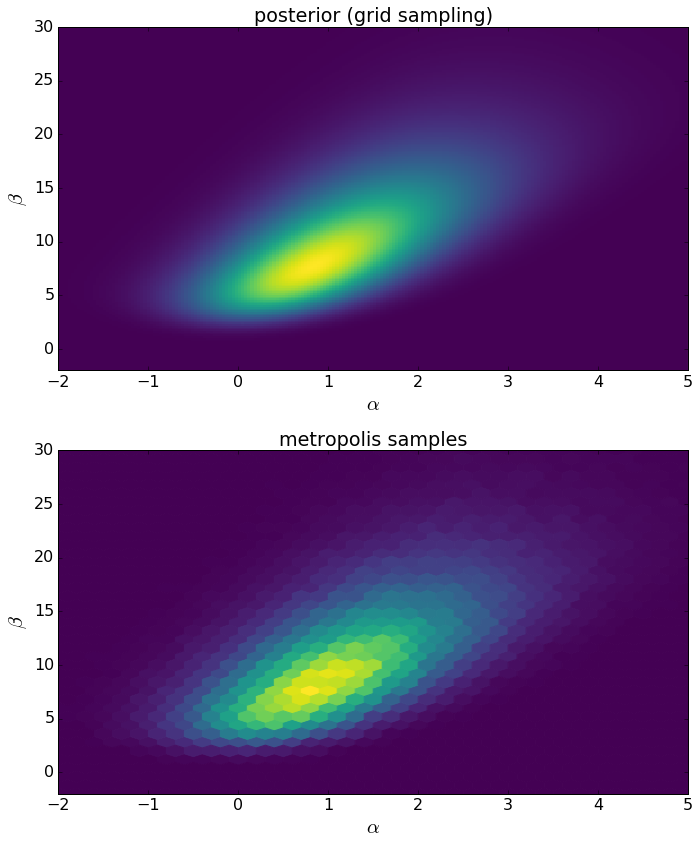

Efficiency: 0.162042 R: [ 1.01241792  1.0251445 ]


In [11]:
# ====== Plotting
plt.figure(figsize=(10, 12))

plt.subplot(2, 1, 1)
plt.xlim([A[0], A[-1]])
plt.ylim([B[0], B[-1]])
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel(r'$\beta$', fontsize=20)
plt.title('posterior (grid sampling)')
plt.imshow(grid_posterior, origin='lower', aspect='auto', extent=(A[0], A[-1], B[0], B[-1]), interpolation='none')

plt.subplot(2, 1, 2)
plt.xlim([A[0], A[-1]])
plt.ylim([B[0], B[-1]])
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel(r'$\beta$', fontsize=20)
plt.title('metropolis samples')
plt.hexbin(samples[:,:,0].flatten(), samples[:,:,1].flatten(), extent=(A[0], A[-1], B[0], B[-1]), gridsize=35)
plt.tight_layout()
plt.show()

print "Efficiency: %f R: %s" % (eff, R)

The results above used
 * Proposal distribution $p(\alpha, \beta|\mu) = N_2(\mu, 5)$
 * 1000 chains with starting points $\alpha, \beta \sim N_2(0, 10)$
 * 2000 warm-up samples
 * 2000 samples

### 2. Generalized linear model: Bioassay with Stan (6 points)

*** Replicate the computations for the bioassay example of section 3.7 (BDA3) using Stan. *** 

Information and hints:

 * See the Stan demos on how to use Stan from Matlab/Python.
 * In Matlab, you need to call addpath in order to use Stan.
 * In Python, you can use Stan by importing the module pystan.
 * Use uniform prior as in the book $p(\alpha, \beta) \propto 1$.
 * Use the PSRF $\hat{R}$ to assess convergence. Note that Stan gives you this automatically, in Matlab you can type fit.print() and in Python print fit to get the convergence information. Here fit is the fit object returned by function stan.
 * You can evaluate the posterior density in a grid (asinassignment 3) and visualize it with the samples to make sure that the samples correspond to the density.
 * Stan manual can be found at http://mc-stan.org/documentation/
 * Useful Stan function: binomial_logit

In [15]:
import pystan

code = """
data {
    int<lower=0> J; // number of different doses
    real x[J]; // dose
    int<lower=0> n[J]; // number of exposed rats
    int<lower=0> y[J]; // number of dead rats
}
parameters {
    real alpha;
    real beta;
}
transformed parameters {
    real logits[J];
    for (j in 1:J)
        logits[j] <- alpha + beta * x[j];
}
model {
    y ~ binomial_logit(n, logits);
}
"""

fit = pystan.stan(model_code=code, data=data, iter=4000, chains=1000)
params = fit.extract()
print fit

Inference for Stan model: anon_model_b75ee51299b4b879c304165dd4e253a7.
1000 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=2000000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       1.31  2.0e-3    1.1   -0.6   0.54   1.22   1.97   3.73 293619    1.0
beta       11.59    0.01   5.77   3.37   7.32  10.61  14.77  25.35 268660    1.0
logits[0]  -8.66  8.1e-3   4.33  -19.1 -10.96  -7.89  -5.51  -2.54 288003    1.0
logits[1]  -2.17  2.1e-3   1.31   -5.3  -2.86  -1.97  -1.26  -0.15 380529    1.0
logits[2]   0.73  1.6e-3   0.94  -0.96   0.09   0.67    1.3   2.75 332997    1.0
logits[3]   9.77  9.8e-3    5.0   2.45   6.06   8.99  12.62  21.53 259591    1.0
lp__       -7.01  2.1e-3   1.11 -10.01  -7.44  -6.66  -6.21  -5.92 281899    1.0

Samples were drawn using NUTS(diag_e) at Thu Feb 25 15:39:00 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the po

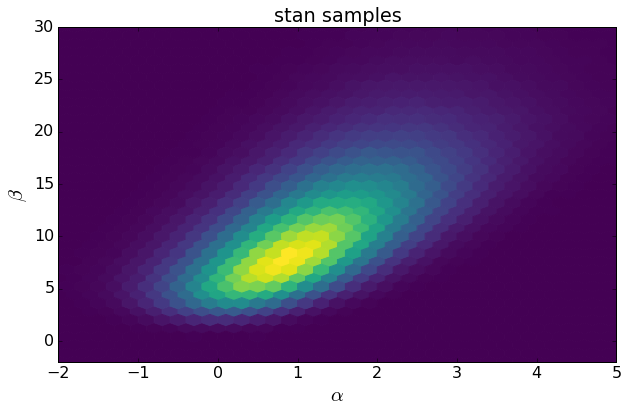

In [27]:
# ====== Plotting
plt.figure(figsize=(10, 6))
plt.xlim([A[0], A[-1]])
plt.ylim([B[0], B[-1]])
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel(r'$\beta$', fontsize=20)
plt.title('stan samples')
plt.hexbin(params['alpha'], params['beta'], extent=(A[0], A[-1], B[0], B[-1]), gridsize=35)
plt.show()